# The Hierarchical Risk Portfolio

In this notebook, we give annotated step-by-step instructions on how to build the hierarchical risk parity portfolio (HRP).

HRP is an portfolio construction algorithm propoed by Marcos López de Prado in 2016. Unlike traditional techniques such as mean-variance optimization or classic risk parity, HRP uses hierarchical clustering and graph theory to allocate weights across assets.

HRP avoids the pitfalls of estimating and inverting covariance matrices (which can be unstable) by following three major steps:
1. Hierarchical Clustering: Assets are clustered based on their similarities (typically using return correlations), forming a hierarchical tree or dendrogram structure.
2. Quasi-Diagonalization: The correlation/covariance matrix is reordered so that similar (correlated) assets appear adjacent—creating a block-diagonal matrix that reflects the hierarchical asset groups.
3. Recursive Bisection: Portfolio weights are assigned recursively, splitting the portfolio into clusters and allocating risk according to the inverse variance within each cluster and between clusters.

HRP does not require the correlation matrix to be positive semi-definite, which solves many headaches in practical application. Compared to portfolios on the efficient froniert, HRP is typically less prone to concentration risk. How HRP performs relative to related allocation strategies in backtests depends very much on the asset universe and time period used in the calculations.

Below step-by-step explanations on how to implement HRP in Python when the starting point is an asset return matrix. Note that this code was designed for educational purposes only. There exist many refinements and more efficient code to implement HRP for investment purposes.

Before we can start, we need to load (and maybe first pip install) some libraries.

In [1]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt

## Step 1: Compute the asset correlation matrix

First, load the asset return data.

In [2]:
returns = pd.read_csv("data.csv", index_col=0, parse_dates=True)

Then calculate the correlation matrix.

In [3]:
corr = returns.corr()

## Step 2: Convert correlations to a distance matrix for clustering

Apply one of the many available methods to transform correlation coefficients into distances.

In [4]:
dist = np.sqrt(0.5 * (1 - corr))

## Step 3: Hierarchical clustering using single linkage

Perform hiearchical clustering.

In [5]:
linkage_matrix = sch.linkage(distance.squareform(dist.values), method='single')

Order the assets (seriation)

In [6]:
asset_order = sch.leaves_list(linkage_matrix)
ordered_assets = [returns.columns[i] for i in asset_order]

Visualise the cluster algorithm results in a dendrogram.

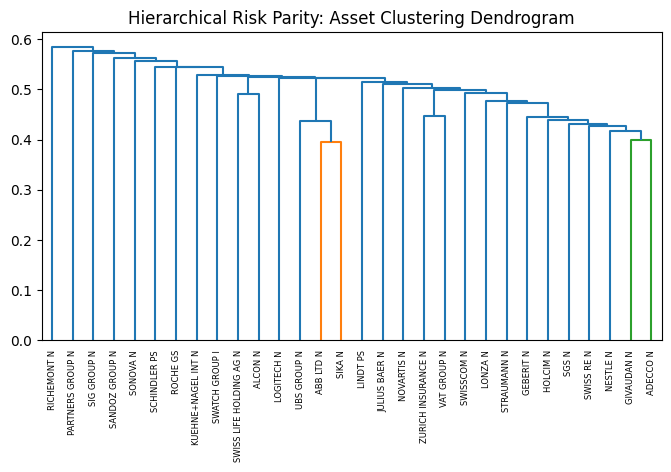

In [7]:
plt.figure(figsize=(8, 4))
sch.dendrogram(linkage_matrix, labels=ordered_assets, leaf_font_size=6)
plt.title("Hierarchical Risk Parity: Asset Clustering Dendrogram")
plt.xticks(rotation=90)
plt.show()

## Step 4: Reorder the covariance matrix for quasi-diagonal structure

In [8]:
cov = returns.cov().values
cov_sorted = cov[asset_order][:, asset_order]

## Step 5: Recursive bisection for HRP portfolio allocation

We first define some internal helper functions.

cluster_variance computes the variance of a subset (cluster) of assets given a covariance matrix. It extracts the relevant sub-covariance matrix for the assets in indices. Then it calculates the inverse-variance portfolio (IVP) weights for those assets. The function calculates and returns the portfolio variance of that cluster using those IVP weights.

In [9]:
def cluster_variance(cov, indices):
    cov_ = cov[np.ix_(indices, indices)]
    ivp = 1 / np.diag(cov_)
    weights = ivp / ivp.sum()
    return np.dot(weights, cov_.dot(weights))

The function recursive_bisect allocates portfolio weights recursively across clusters of assets. If a cluster contains more than one asset, it is bisected into left and right halves. For each half, their cluster variance is computed (using cluster_variance). The allocation between left and right is based on their relative variance: the cluster with lower variance gets higher weight. Weights for assets in each cluster are multiplied by their allocation proportion. The new clusters are gathered for further bisection. This process continues until each cluster has only one asset; weights will then represent the final risk allocations.

In [10]:
def recursive_bisect(cov, indices):
    weights = pd.Series(1.0, index=indices)
    clusters = [indices]
    while clusters:
        new_clusters = []
        for cluster in clusters:
            if len(cluster) == 1:
                continue
            split = len(cluster)//2
            left, right = cluster[:split], cluster[split:]
            left_var = cluster_variance(cov, left)
            right_var = cluster_variance(cov, right)
            alloc_left = right_var / (left_var + right_var)
            alloc_right = left_var / (left_var + right_var)
            weights[left] *= alloc_left
            weights[right] *= alloc_right
            new_clusters += [left, right]
        clusters = new_clusters
    return weights

The above functions to most of the legwork. Once we have them, the calculation of the HRP allocation is easy.

In [11]:
indices = list(range(len(asset_order)))
hrp_weights = recursive_bisect(cov_sorted, indices)
hrp_weights = pd.Series(hrp_weights.values, index=ordered_assets)
hrp_weights /= hrp_weights.sum()  # Normalize to sum to 1

This is it. We can visualize the allocation as a barplot.

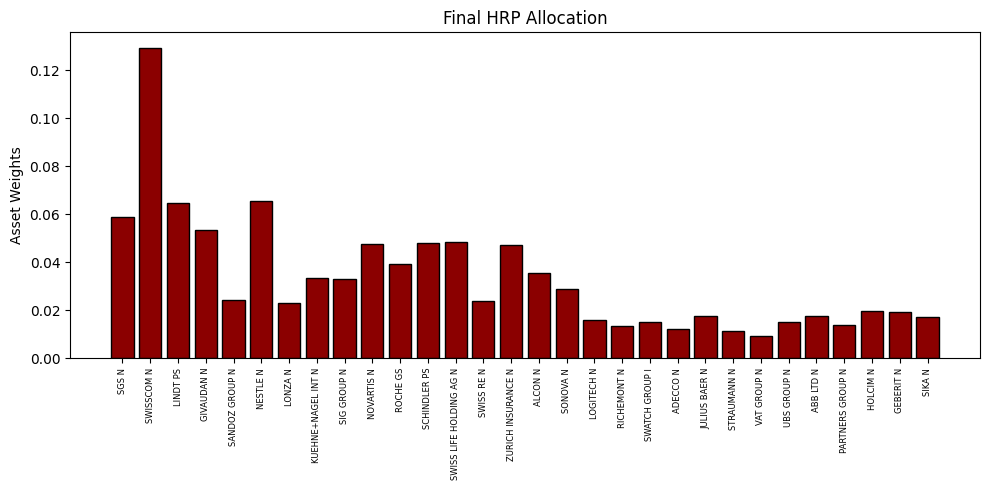

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(hrp_weights.index, hrp_weights.values, color='darkred', edgecolor='black')
ax.set_title('Final HRP Allocation')
ax.set_ylabel('Asset Weights')
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=6)
plt.tight_layout()
plt.show()